In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/train_all_tasks.csv')

In [ ]:
df = df[['label_category','text']]
df.rename(columns={ 'text':'message','label_category':'category'}, inplace=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  14000 non-null  object
 1   message   14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


<ipython-input-4-df00e594e5f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={ 'text':'message','label_category':'category'}, inplace=True)


In [ ]:
# # '1. threats, plans to harm and incitement','2. derogation',
#  '3. animosity', '4. prejudiced discussions', 'none'

In [ ]:
# downsample none
category_counts = df['category'].value_counts()

# Get the count of the 2nd largest category
smallest_category_count = category_counts.head(5).iloc[4]

not_sexist_msg = df[df['category'] == 'none']
threat_msg = df[df['category'] == '1. threats, plans to harm and incitement']
dero_msg = df[df['category'] == '2. derogation']
anim_msg = df[df['category'] == '3. animosity']
judi_msg = df[df['category'] == '4. prejudiced discussions']


sexist_msg = df[df['category'] != 'none']

not_sexist_msg_df = not_sexist_msg.sample(n = smallest_category_count, random_state = 44)
threat_msg = threat_msg.sample(n = smallest_category_count, random_state = 45)
dero_msg = dero_msg.sample(n = smallest_category_count, random_state = 46)
anim_msg = anim_msg.sample(n = smallest_category_count, random_state = 47)
judi_msg = judi_msg.sample(n = smallest_category_count, random_state = 48)
sexist_msg_df = sexist_msg



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
judi_msg.head()

,category,message
9656,4. prejudiced discussions,All you gotta do is look at the size of her an...
13808,4. prejudiced discussions,Sooner or later she is going to be the recipie...
8969,4. prejudiced discussions,The funny thing is...she's rignt. Because men ...
6801,4. prejudiced discussions,"Honestly, i feel like it's easier to just not ..."
9873,4. prejudiced discussions,"If anything, it's the men that are exploited....."


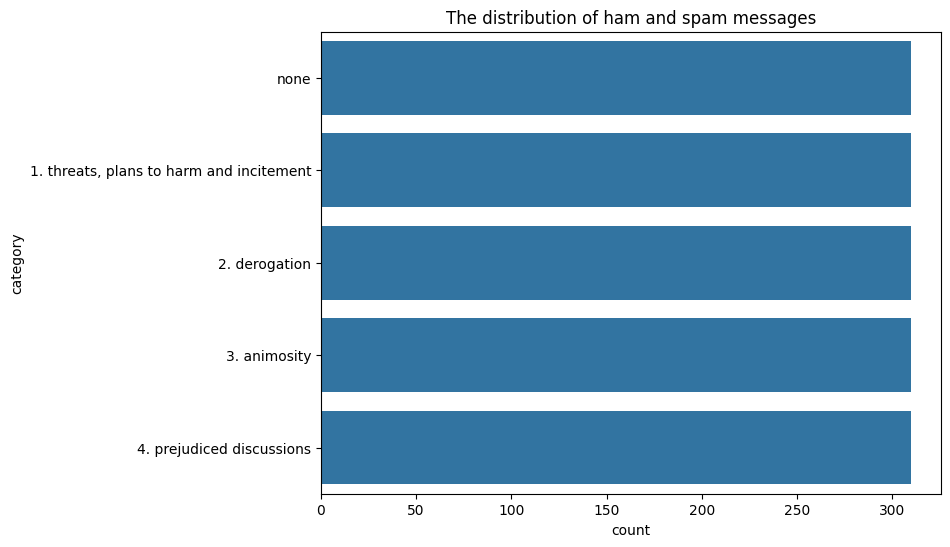

In [ ]:
# Concatenating downsampled ham messages and spam messages
balanced_df = pd.concat([not_sexist_msg_df, threat_msg,dero_msg, anim_msg, judi_msg])

# Plot the distribution of ham and spam messages
plt.figure(figsize=(8, 6))
sns.countplot(balanced_df['category'])
plt.title('The distribution of ham and spam messages')
plt.show()

In [ ]:
# from keras.utils.np_utils import to_categorical
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
# STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
balanced_df['message'] = balanced_df['message'].apply(clean_text)

In [ ]:
balanced_df['message'] = balanced_df['message'].str.replace('\d+', '')
balanced_df['message'] = balanced_df['message'].str.replace('â', '')
balanced_df['message'] = balanced_df['message'].str.replace('€', '')
balanced_df['message'] = balanced_df['message'].str.replace('™', '')
balanced_df['message'] = balanced_df['message'].str.replace('ð', '')
balanced_df['message'] = balanced_df['message'].str.replace('Ÿ', '')
balanced_df['message'] = balanced_df['message'].str.replace('˜', '')
balanced_df['message'] = balanced_df['message'].str.replace('©', '')
balanced_df['message'] = balanced_df['message'].str.replace('‡', '')
balanced_df['message'] = balanced_df['message'].str.replace('ª', '')

In [ ]:
X = balanced_df['message'].values
Y = balanced_df['category'].values

In [ ]:
# Tokenize the text data
max_words = 500  # Maximum number of words to tokenize
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [ ]:
# Pad sequences to ensure uniform length
max_seq_length = 200  # Maximum sequence length
X_padded = pad_sequences(X_seq, maxlen=max_seq_length, padding='post')

In [ ]:
# Encode sexism categories into numerical labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_encoded, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(5, activation='softmax'))
# lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(lstm_model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 128)          64000     
                                                                 
 spatial_dropout1d_6 (Spati  (None, 200, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_11 (LSTM)              (None, 200, 128)          131584    
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
# Train LSTM model
epochs = 2
batch_size = 64
history_lstm = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
18/18 [==============================] - 26s 1s/step - loss: 1.6110 - accuracy: 0.1935 - val_loss: 1.6106 - val_accuracy: 0.1855
Epoch 2/2
18/18 [==============================] - 25s 1s/step - loss: 1.6094 - accuracy: 0.2088 - val_loss: 1.6120 - val_accuracy: 0.1855


In [ ]:
accr = lstm_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10/10 [==============================] - 1s 127ms/step - loss: 1.6127 - accuracy: 0.1839
Test set
  Loss: 1.613
  Accuracy: 0.184


In [ ]:
# Function to preprocess new input text
def preprocess_input(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)
    return padded

# Sample input text
new_text = "You're a retard, he was not picking sides and saying who's right and wrong, just that the girl didn't think she was above his reaction/ had a pussy pass."
# Preprocess the input text
processed_text = preprocess_input(new_text)

# Make predictions
predictions = lstm_model.predict(processed_text)
print("Raw output scores:", predictions)
# Decode the predicted label
predicted_label = label_encoder.inverse_transform([predictions.argmax()])[0]

print("Predicted label:", predicted_label)


1/1 [==============================] - 0s 158ms/step
Raw output scores: [[0.19794449 0.20242766 0.19617756 0.20411414 0.19933616]]
Predicted label: 4. prejudiced discussions
